In [61]:
from hydra import initialize, compose
import json
from rdkit import Chem
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.standardize import standardize_mol
from ergochemics.mapping import rc_to_nest
from IPython.display import SVG
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [62]:
with initialize(version_base=None, config_path="./conf/filepaths"):
    filepaths = compose(config_name="filepaths")

In [63]:
entries = {}
for i in range(0, 11):
    with open(Path(filepaths.raw_mcsa) / f"entries_{i}.json", "r") as f:
        entries = {**entries, **json.load(f)}

mech_ct = 0
detailed_ct = 0
for id, entry in entries.items():
    mechanisms = entry['reaction']['mechanisms']
    if mechanisms is None:
        continue

    for mech in mechanisms:
        mech_ct += 1
        if mech['is_detailed']:
            detailed_ct += 1

print(f"Total number of mechanisms: {mech_ct}")
print(f"Number of detailed mechanisms: {detailed_ct} ({detailed_ct/mech_ct*100:.2f}%)")
print(f"Total number of entries: {len(entries)}")


Total number of mechanisms: 1166
Number of detailed mechanisms: 887 (76.07%)
Total number of entries: 1003


In [64]:
mech_df = pd.read_parquet(Path(filepaths.processed_data) / 'mcsa' / "distilled_mech_reactions.parquet")
mech_df["mech_atoms"] = mech_df["mech_atoms"].apply(rc_to_nest)
mech_df['reaction_center'] = mech_df['reaction_center'].apply(rc_to_nest)
n_unique = len(set(mech_df[["entry_id", "mechanism_id"]].apply(tuple, axis=1)))
print(f"{n_unique/detailed_ct*100:.2f}% of detailed mechanisms have been processed")
mech_df.head(10)

75.42% of detailed mechanisms have been processed


,entry_id,mechanism_id,smarts,am_smarts,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec
0,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:33][C:32](=[O:35])[NH:30][CH:16]1[C:17](=[O...,"(((5, 7), (0,)), ((5, 7, 9),))","(((6,), ()), ((6,),))",beta-lactamase (Class A),P62593,3.5.2.6
1,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:51][C:50](=[O:52])[NH:48][CH:33]1[C:35](=[O...,"(((5, 7), (0,)), ((5, 7, 9),))","(((6,), ()), ((6,),))",beta-lactamase (Class A),P62593,3.5.2.6
2,3,1,*N1C=CCC(C(N)=O)=C1.O=C1C=CC(=O)C=C1>>*[n+]1cc...,[*:53][N:38]1[CH:37]=[CH:36][CH2:41][C:40]([C:...,"(((1, 2, 3, 4, 5, 9), (0, 1, 2, 3, 4, 5, 6, 7)...","(((), ()), ((), ()))",NAD(P)H dehydrogenase (quinone),P15559,1.6.5.2
3,4,2,O=NO>>N=O.O,[O:52]=[N:53][OH:54]>>[NH:53]=[O:52].[OH2:54],"(((1, 2),), ((0,), (0,)))","(((0,),), ((1,), ()))",nitrite reductase (copper type),P25006,1.7.2.1
4,4,1,O=NO>>N=O.O,[O:68]=[N:69][OH:70]>>[NH:69]=[O:68].[OH2:70],"(((1, 2),), ((0,), (0,)))","(((0,),), ((1,), ()))",nitrite reductase (copper type),P25006,1.7.2.1
5,5,1,*C(C)C(=O)NC(*)C(=O)O.O>>*C(C)C(=O)O.*C(N)C(=O)O,[*:41][CH:32]([CH3:42])[C:33](=[O:40])[NH:34][...,"(((3, 5), (0,)), ((3, 5), (2,)))","(((4,), ()), ((4,), ()))",carboxypeptidase D,P08819,3.4.16.6
6,6,1,NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...,[NH2:125][C:123](=[O:124])[C:119]1=[CH:117][N:...,"(((3, 4, 5, 45, 46, 47), (9, 10)), ((3, 4, 5, ...","(((), ()), ((), (), ()))",glutathione-disulfide reductase,P00390,1.8.1.7
7,7,2,NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...,[NH2:58][C:55](=[O:57])[c:52]1[cH:54][cH:53][c...,"(((3, 4, 5, 6, 7, 47), (4, 5, 7, 8, 9)), ((3, ...","(((), (12,)), ((), (9,), ()))",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42
8,7,1,NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...,[NH2:58][C:55](=[O:57])[c:52]1[cH:54][cH:53][c...,"(((3, 4, 5, 6, 7, 47), (4, 5, 7, 8, 9)), ((3, ...","(((), (12,)), ((), (9,), ()))",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42
9,7,3,NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...,[NH2:58][C:55](=[O:57])[c:52]1[cH:54][cH:53][c...,"(((3, 4, 5, 6, 7, 47), (4, 5, 7, 8, 9)), ((3, ...","(((), (12,)), ((), (9,), ()))",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42


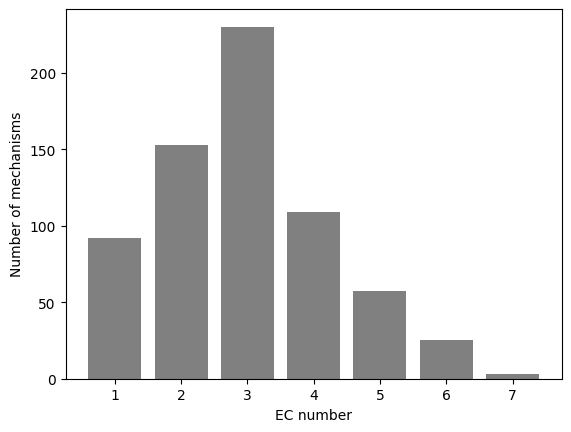

In [65]:
ecs = []
n_digits = 1
for eid in mech_df['entry_id']:
    ecs.append(entries[str(eid)]['reaction']['ec'])

ec_trunc = [elt[:n_digits] for elt in ecs]
ec_counts = Counter(ec_trunc)
ec_counts = sorted(ec_counts.items(), key=lambda x: x[0])

fig, ax = plt.subplots()
x = [i for i in range(len(ec_counts))]
ax.bar(x, [elt[1] for elt in ec_counts], color='gray')
ax.set_xticks(x)
ax.set_xticklabels([elt[0] for elt in ec_counts])
ax.set_xlabel('EC number')
ax.set_ylabel('Number of mechanisms')
plt.show()

In [66]:
mech_df.loc[mech_df['entry_id'] == 49]

,entry_id,mechanism_id,smarts,am_smarts,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec
47,49,1,NC(Cc1c[nH]cn1)C(=O)O>>NCCc1c[nH]cn1.O=C=O,[NH2:41][CH:42]([CH2:40][c:51]1[cH:49][nH:47][...,"(((1, 8, 10),), ((1,), (1, 2)))","(((0,),), ((0,), ()))",histidine decarboxylase,P00862,4.1.1.22


In [67]:
def display_mech_labeled_rxn(entry_id: int, de_am: bool = False):
    these_mechs = mech_df.loc[mech_df['entry_id'] == entry_id]
    for _, row in these_mechs.iterrows():
        print(f"Mechanism: #{row['mechanism_id']}")
        smarts = row['am_smarts']
        lhs = [Chem.MolFromSmiles(elt) for elt in smarts.split('>>')[0].split('.')]
        rc_aidxs = row['reaction_center']
        mech_aidxs = row['mech_atoms']
        
        if de_am:
            for mol in lhs:
                for atom in mol.GetAtoms():
                    atom.SetAtomMapNum(0)

            smarts = '.'.join([Chem.MolToSmiles(mol) for mol in lhs]) + '>>' + smarts.split('>>')[1]
        
        # Display
        display(SVG(draw_reaction(smarts, sub_img_size=(150, 100))))
        for rct, rc, mech in zip(lhs, rc_aidxs[0], mech_aidxs[0]):
            involved_atoms = list(rc)
            print(involved_atoms)
            display(SVG(draw_molecule(rct, size=(300, 200), highlight_atoms=involved_atoms, draw_options={"addAtomIndices": True})))

Mechanism: #1


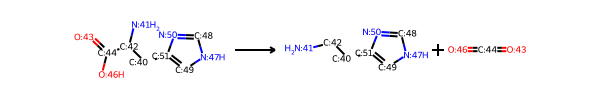

[1, 8, 10]


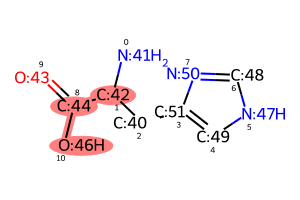

In [68]:
display_mech_labeled_rxn(49)

Mechanism: #1


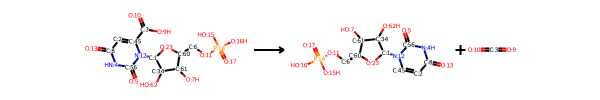

[1, 2, 3]


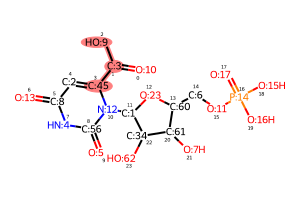

Mechanism: #3


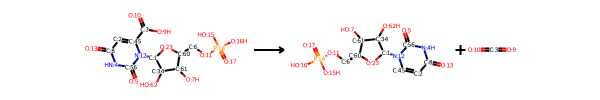

[1, 2, 3]


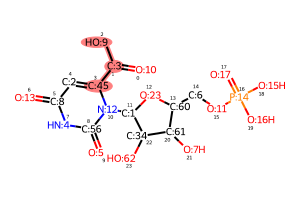

Mechanism: #2


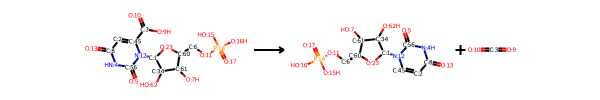

[1, 2, 3]


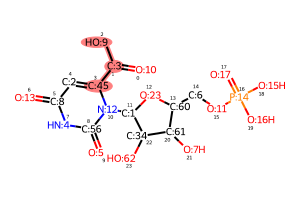

In [69]:
display_mech_labeled_rxn(50)

In [79]:
display_mech_labeled_rxn(722)

Mechanism: #1


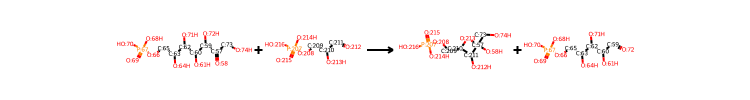

[0, 1, 4, 5]


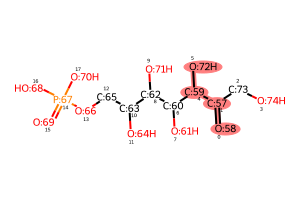

[0, 1, 3]


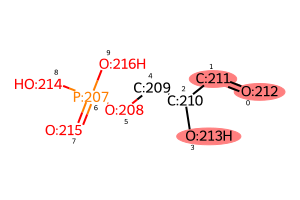

In [71]:
display_mech_labeled_rxn(219)

Mechanism: #2


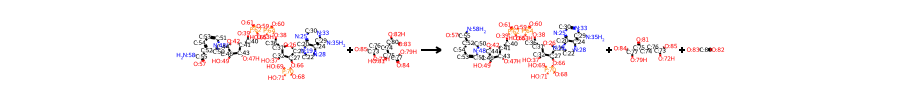

[3, 4, 5, 6, 7, 47]


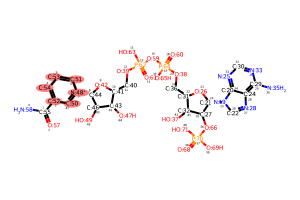

[4, 5, 7, 8, 9]


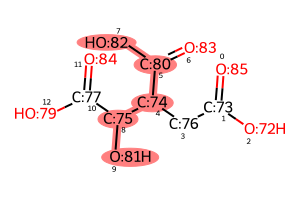

Mechanism: #1


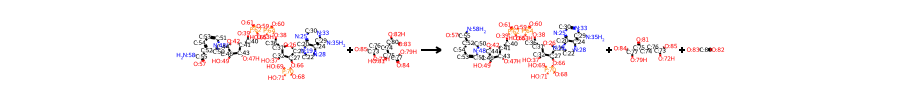

[3, 4, 5, 6, 7, 47]


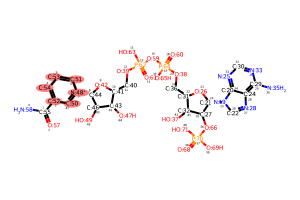

[4, 5, 7, 8, 9]


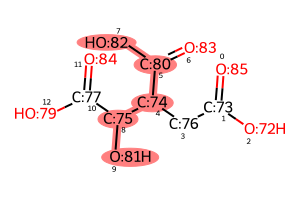

Mechanism: #3


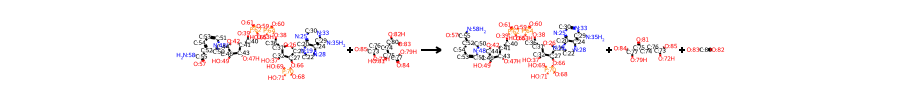

[3, 4, 5, 6, 7, 47]


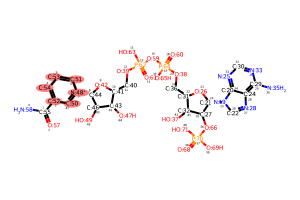

[4, 5, 7, 8, 9]


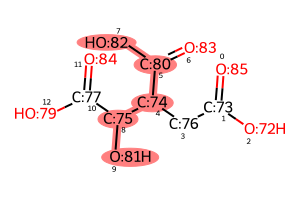

In [72]:
display_mech_labeled_rxn(7)

Mechanism: #2


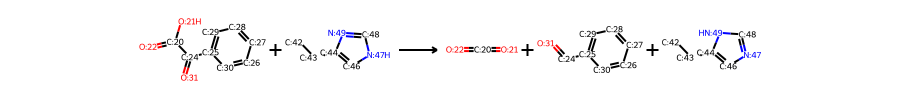

[1, 2, 3]


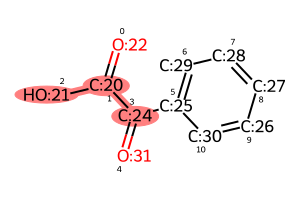

[]


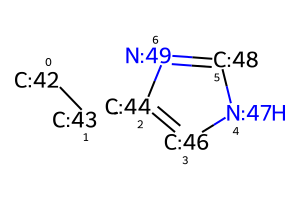

Mechanism: #3


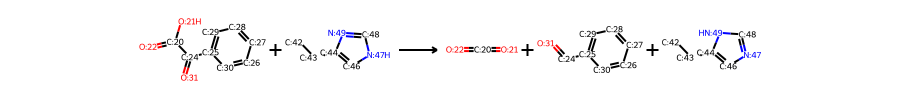

[1, 2, 3]


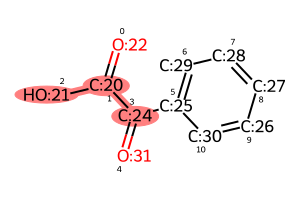

[]


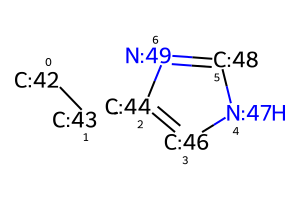

Mechanism: #1


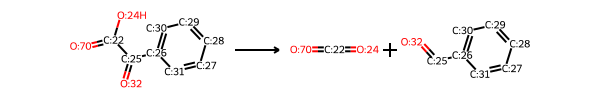

[1, 2, 3]


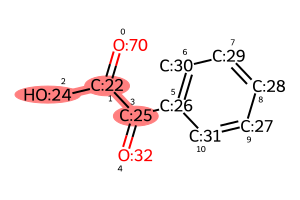

In [73]:
display_mech_labeled_rxn(220)

Mechanism: #1


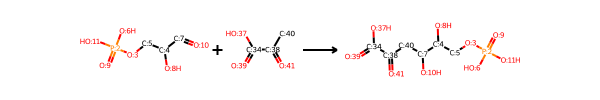

[0, 1]


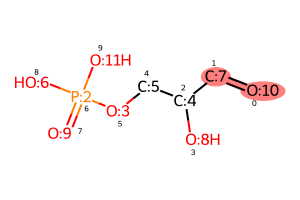

[0]


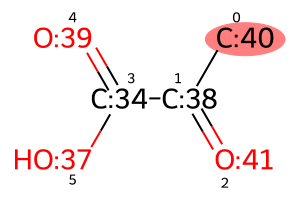

In [74]:
display_mech_labeled_rxn(550)

Mechanism: #1


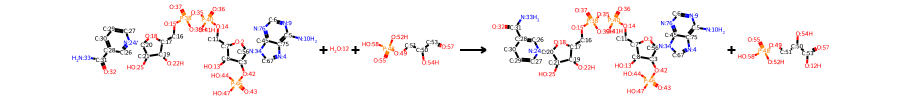

[3, 4, 5, 6, 7, 47]


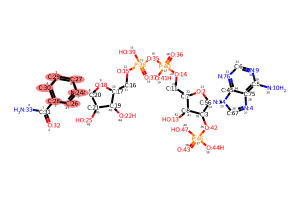

[0]


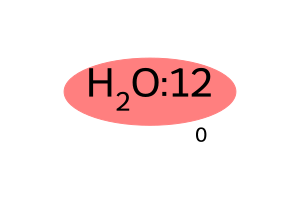

[1]


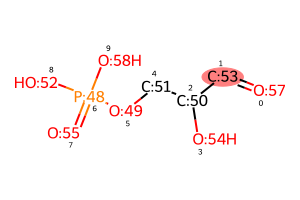

In [78]:
display_mech_labeled_rxn(711)

In [76]:
mm = pd.read_parquet(
    Path(filepaths.processed_data) / "mcsa" / "mapped_mech_labeled_reactions.parquet"
)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec
0,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:33][C:32](=[O:35])[NH:30][CH:16]1[C:17](=[O...,"1,4;0>>1,4,7","5,6,7;>>5,6,9",beta-lactamase (Class A),P62593,3.5.2.6
1,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:51][C:50](=[O:52])[NH:48][CH:33]1[C:35](=[O...,"0,3,16;>>0,3,13","5,6,7;0>>5,6,7,9",beta-lactamase (Class A),P62593,3.5.2.6
2,3,1,*N1C=CCC(C(N)=O)=C1.O=C1C=CC(=O)C=C1>>*[n+]1cc...,[*:53][N:38]1[CH:37]=[CH:36][CH2:41][C:40]([C:...,"0,1,2,3,4,5;0,1,2,3,4,5,6,7>>0,1,2,3,4,5;0,1,2...",;>>;,NAD(P)H dehydrogenase (quinone),P15559,1.6.5.2
3,4,2,O=NO>>N=O.O,[O:52]=[N:53][O-:54]>>[NH2+:53]=[O:52].[OH2:54],"1,2>>0;0",0>>1;,nitrite reductase (copper type),P25006,1.7.2.1
4,4,1,O=NO>>N=O.O,[O:68]=[N:69][OH:70]>>[NH:69]=[O:68].[OH-:70],"1,2>>0;0",0>>1;,nitrite reductase (copper type),P25006,1.7.2.1


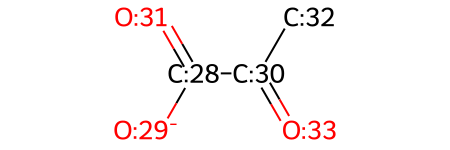

In [77]:
Chem.MolFromSmarts('[#6:28](-[#8-:29])(-[#6:30](-[#6H3:32])=[#8:33])=[#8:31]')